In [47]:
import pkg_resources
pkg_resources.require("matplotlib==3.1.2")

import pandas as pd
import base64
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import lzma
from sklearn.model_selection import KFold
from multiprocessing.dummy import Pool
from urllib.parse import urlparse

# Посмотрим, не ссылаются ли страницы на страницы со спамом. На сайты, на которых есть страницы со спамом?

In [26]:
df_train = pd.read_csv("/Users/michelle/data/kaggle_train_data_tab.csv", sep='\t')
# df_test = pd.read_csv("/Users/michelle/data/kaggle_test_data_tab.csv", sep='\t')

In [6]:
def get_content(page_base64):
    try:
        return BeautifulSoup(base64.b64decode(page_base64).decode("utf-8"), "html.parser")
    except UnicodeDecodeError:
        return

In [5]:
def get_a_tags(page_base64):
    content = get_content(page_base64)
    if content:
        return content.find_all("a")

In [8]:
train_foreign_links = []

for page_base64 in tqdm(list(df_train["PageBase64"]), total=df_train.shape[0]):
    a_tags = get_a_tags(page_base64)
    if a_tags:
        links = [tag.get("href") for tag in a_tags if tag]
        foreign_links = [link for link in links if (link and (link[:4] == "http"))]
        train_foreign_links.append(foreign_links)
    else:
        train_foreign_links.append([])

In [11]:
train_spam_urls = set(df_train[df_train["Prediction"] == 1]["Url"])

In [27]:
train_urls = set(df_train["Url"])

In [9]:
flat_train_foreign_links = []
for page in train_foreign_links:
    for link in page:
        flat_train_foreign_links.append(link)

In [56]:
len(train_urls & set(flat_train_foreign_links))

1010

In [13]:
len(train_spam_urls & set(flat_train_foreign_links))

536

In [37]:
train_links_to_spam = [int(len(set(links) & train_spam_urls) > 0) for links in train_foreign_links]
df_train["links_to_spam"] = np.array(train_links_to_spam)

In [16]:
df_train[(df_train["links_to_spam"] == 1) & (df_train["Prediction"] == 1)].shape[0]

552

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


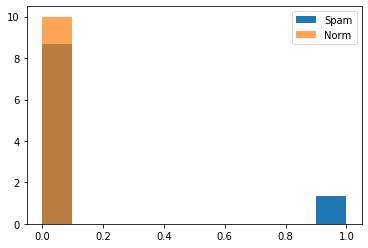

In [17]:
plt.hist(df_train[(df_train["Prediction"] == 1)]["links_to_spam"], label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0)]["links_to_spam"], label="Norm", normed=True, alpha=0.7)
plt.legend();

In [19]:
df_sub = pd.read_csv("antispam_submission_06_05.csv")
df_sub = pd.merge(df_sub, df_test.loc[:, ["Id", "Url"]], on=["Id"])
test_predicted_links = set(df_sub[df_sub["Prediction"] == 1]["Url"])

In [20]:
del df_train

In [21]:
test_foreign_links = []

for page_base64 in tqdm(list(df_test["PageBase64"]), total=df_test.shape[0]):
    a_tags = get_a_tags(page_base64)
    if a_tags:
        links = [tag.get("href") for tag in a_tags if tag]
        foreign_links = [link for link in links if (link and (link[:4] == "http"))]
        test_foreign_links.append(foreign_links)
    else:
        test_foreign_links.append([])

In [22]:
flat_test_foreign_links = []
for page in test_foreign_links:
    for link in page:
        flat_test_foreign_links.append(link)

In [44]:
test_urls = set(df_test["Url"])

In [45]:
len(test_urls & set(flat_test_foreign_links))

1352

In [23]:
len(train_spam_urls & set(flat_test_foreign_links))

3

# Плохое пересечение ссылок в тестовой выборке и урлов обучающей. Посмотрим, как часто ссылки тестовой выборки ведут на урлы, которые мы предсказали как спам старой моделью

In [24]:
len(test_predicted_links & set(flat_test_foreign_links))

852

In [32]:
test_links_to_spam = [int(len(set(links) & test_predicted_links) > 0) for links in test_foreign_links]
df_sub["links_to_spam"] = np.array(test_links_to_spam)

In [39]:
df_sub["Prediction_links"] = df_sub["Prediction"] | df_sub["links_to_spam"]

In [40]:
df_sub["Prediction_links"].sum()

7787

In [41]:
df_sub["Prediction"].sum()

7703

In [42]:
df_sub["Prediction"] = df_sub["Prediction_links"]
df_sub.loc[:, ["Id", "Prediction"]].to_csv("antispam_submission_06_06.csv", index=False)

# Модель недостаточно точная, чтобы уточнять ее с использованием ссылок на предсказанный спам. Оставим эту идею на потом. Посмотрим на сайты

In [49]:
def get_hostname(url):
    parsed_uri = urlparse(url)
    result = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return result

In [50]:
flat_train_foreign_hostnames = [get_hostname(url) for url in flat_train_foreign_links]

In [59]:
train_hosts = [get_hostname(url) for url in train_urls]
train_spam_hosts = [get_hostname(url) for url in train_spam_urls]

In [60]:
len(set(train_hosts) & set(flat_train_foreign_hostnames))

3685

In [62]:
len(set(train_spam_hosts) & set(flat_train_foreign_hostnames))

2300

In [65]:
train_foreign_hosts = []
for links in train_foreign_links:
    hosts = [get_hostname(link) for link in links]
    train_foreign_hosts.append(set(hosts))

In [68]:
train_hosts_to_spam = [int(len(hosts & set(train_spam_hosts)) > 0) for hosts in train_foreign_hosts]
df_train["hosts_to_spam"] = np.array(train_hosts_to_spam)

In [70]:
df_train[(df_train["hosts_to_spam"] == 1) & (df_train["Prediction"] == 1)].shape[0]

2354

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


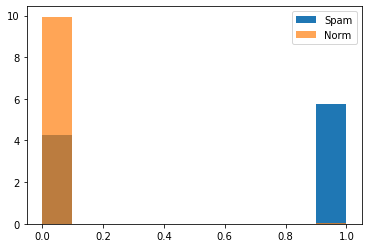

In [71]:
plt.hist(df_train[(df_train["Prediction"] == 1)]["hosts_to_spam"], label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0)]["hosts_to_spam"], label="Norm", normed=True, alpha=0.7)
plt.legend();

In [72]:
flat_test_foreign_hostnames = [get_hostname(url) for url in flat_test_foreign_links]
test_hosts = [get_hostname(url) for url in test_urls]

In [75]:
len(set(train_hosts) & set(flat_test_foreign_hostnames))

197

In [76]:
len(set(train_spam_hosts) & set(flat_test_foreign_hostnames))

57

In [94]:
test_foreign_hosts = []
for links in test_foreign_links:
    hosts = [get_hostname(link) for link in links]
    test_foreign_hosts.append(set(hosts))

In [95]:
df_sub = pd.read_csv("antispam_submission_06_05.csv")
# df_sub = pd.merge(df_sub, df_test.loc[:, ["Id", "Url"]], on=["Id"])
# test_predicted_links = set(df_sub[df_sub["Prediction"] == 1]["Url"])

In [96]:
test_hosts_to_spam = [int(len(hosts & set(train_spam_hosts)) > 0) for hosts in test_foreign_hosts]
df_sub["hosts_to_spam"] = np.array(test_hosts_to_spam)

In [97]:
df_sub["Prediction"] = df_sub["Prediction"] | df_sub["hosts_to_spam"]
df_sub.loc[:, ["Id", "Prediction"]].to_csv("antispam_submission_06_07.csv", index=False)

In [98]:
df_sub = pd.read_csv("antispam_submission_06_05.csv")
df_sub = pd.merge(df_sub, df_test.loc[:, ["Id", "Url"]], on=["Id"])
test_predicted_links = set(df_sub[df_sub["Prediction"] == 1]["Url"])

In [99]:
test_predicted_hosts = [get_hostname(url) for url in test_predicted_links]

In [100]:
len(set(test_predicted_hosts) & set(flat_test_foreign_hostnames))

4111

In [101]:
test_hosts_to_spam = [int(len(set(hosts) & set(test_predicted_hosts)) > 0) for hosts in test_foreign_hosts]
df_sub["hosts_to_spam"] = np.array(test_hosts_to_spam)

In [104]:
df_sub["Prediction"] = df_sub["Prediction"] | df_sub["hosts_to_spam"]

In [106]:
df_sub.loc[:, ["Id", "Prediction"]].to_csv("antispam_submission_06_08.csv", index=False)

In [111]:
len(set(train_hosts) & set(test_hosts)) / len(set(train_hosts) ^ set(test_hosts))

0.0012038269023633022

In [114]:
len(set(train_hosts) & set(flat_train_foreign_hostnames)) / len(set(train_hosts) ^ set(flat_train_foreign_hostnames))

0.058867695453528865

In [115]:
len(set(test_hosts) & set(flat_test_foreign_hostnames)) / len(set(test_hosts) ^ set(flat_test_foreign_hostnames))

0.21375848833776204

In [116]:
len(set(train_hosts) & set(flat_test_foreign_hostnames)) / len(set(train_hosts) ^ set(flat_test_foreign_hostnames))

0.004923769057735566

In [117]:
len(set(train_spam_hosts) & set(flat_train_foreign_hostnames)) / len(set(train_spam_hosts) ^ set(flat_train_foreign_hostnames))

0.03646510448045153

In [118]:
len(set(train_spam_hosts) & set(flat_test_foreign_hostnames)) / len(set(train_spam_hosts) ^ set(flat_test_foreign_hostnames))

0.0015001579113590904

In [121]:
len(set(test_hosts) & set(test_predicted_hosts)) / len(set(test_hosts) ^ set(test_predicted_hosts))

1.8383808095952023

# Итак, пересечение по ссылкам и сайтам из html тестовой выборки с урлами обучающей слишком мало, чтобы как-то повлиять на качество классификации. Попытка забанить сайты или страницы, содержащие ссылки на страницы, помеченные логистической регрессией по 5 признакам как спам, приводят к ухудшению качества. 4 часа на это. Грустно и невкусно